In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


poe_path = f"../mask_token.csv"
raw_df = pd.read_csv(poe_path)

# rename mask_token: nan to "empty"
raw_df['mask_token'] = raw_df['mask_token'].fillna("empty")
# the [N/A] is actually N/A in implementation.
# raw_df['mask_token'].unique()

array(['[MASK]', '[N/A]', 'dasjhasjkdhjskdhds', 'empty', '[mask]'],
      dtype=object)

In [2]:
def process(df, drop_columns=None): 
    # get rid of identical rows 
    df = df.drop_duplicates()
    if isinstance(drop_columns, list):
        drop_columns += ["model_family", "seed", "batch_size", "loading_precision", "sample"]
    else:
        drop_columns = ["model_family", "seed", "batch_size", "loading_precision", "sample"]
    df = df.drop(columns=drop_columns)
    # shorten checkpoint names
    df['checkpoint'] = df["checkpoint"].apply(lambda x: x.split("/")[-1])
    return df

def process_v2(df):
    datasets="anli cqa siqa logical_deduction_five_objects disambiguation_qa conceptual_combinations strange_stories symbol_interpretation".split()
    df = df[df["dataset"].isin(datasets)]
    df = df.groupby(["dataset", "checkpoint", "mask_token"]).mean().reset_index()
    df = df.drop(columns=["checkpoint"])
    # accuracy: 3 decimal places
    df["accuracy"] = df["accuracy"].apply(lambda x: round(x, 3))
    return df

In [5]:
mask_token_df = process(raw_df, drop_columns=["n_shot", "prompting_method", "scoring_method", "mask_strategy", "mask_accuracy", "method"])
mask_token_df = process_v2(mask_token_df)

# save to csv
mask_token_df.to_csv("mask_token.csv", index=False)

In [10]:
# Find the index of the row with the highest accuracy for each dataset
max_accuracy_indices = mask_token_df.groupby('dataset')['accuracy'].idxmax()
# Get the rows with the highest accuracy for each dataset
rows_with_highest_accuracy = mask_token_df.loc[max_accuracy_indices]
rows_with_highest_accuracy

,dataset,mask_token,accuracy
4,anli,empty,0.572
6,conceptual_combinations,[N/A],0.792
13,cqa,dasjhasjkdhjskdhds,0.896
16,disambiguation_qa,[N/A],0.682
21,logical_deduction_five_objects,[N/A],0.568
27,siqa,[mask],0.826
34,strange_stories,empty,0.786
35,symbol_interpretation,[MASK],0.234


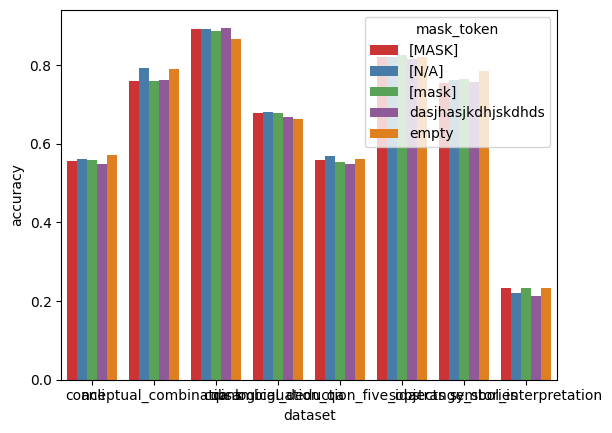

In [8]:
sns.barplot(
    x='dataset', 
    y='accuracy', 
    hue='mask_token', 
    data=mask_token_df, 
    palette='Set1',
    )

plt.show()

In [68]:


# concatenate to df, and sort by dataset
df = pd.concat([lowest_df, min_k_df, below_average_df])
df = df.sort_values(by=["dataset", "mask_strategy"])

# reset the index
df = df.reset_index(drop=True)
# Find the index of the row with the highest accuracy for each dataset
max_accuracy_indices = df.groupby('dataset')['accuracy'].idxmax()
# Get the rows with the highest accuracy for each dataset
rows_with_highest_accuracy = df.loc[max_accuracy_indices]

# save to csv
df.to_csv("min_k_mask.csv", index=False)
rows_with_highest_accuracy.to_csv("min_k_mask_max_accuracy.csv", index=False)